# LCG

## Definicja


```{prf:algorithm} LCG
:label: lcg
**Wejście** $m$ - moduł, $a$ - mnożnik, $c$ - przyrost, $X_0$ - ziarno.

$m, a, c, X_0 \in \mathbb{N}$, 

$m > 0$, 

$a < m$, 

$c < m$, 

$X_0 < m$.

**Wyjście** Wygeneruj ciąg liczb pseudolosowych $X_1, X_2, \ldots, X_n$ zadany przez wzór rekurencyjny:

$$
X_{n+1} = (aX_n + c)\mod m, \quad   n \geq 0
$$
```

## Wdrożenie

In [38]:
from typing import Generator, Tuple

def lcg(m: int, a: int, c: int, X0: int) -> Generator[int, None, None]:
  prevX = X0
  while True:
    prevX = (a * prevX + c) % m
    yield prevX


Ta prosta implementacja algorytmu LCG pozwoli nam popróbować różnych parametrów. Oprócz tego dopiszę parę pomocniczych funkcji:

In [39]:
def print_n(gen: Generator[int, None, None], n: int) -> None:
    print([next(gen) for _ in range(n)])


def get_ranges(
    gen: Generator[int, None, None], range_1: Tuple[int, int], range_2: Tuple[int, int]
) -> Tuple[list[int], list[int]]:
    ret1 = []
    ret2 = []

    for idx, i in enumerate(gen):
        if idx > range_2[1]:
            break
        if range_1[0] <= idx <= range_1[1]:
            ret1.append(i)
        if range_2[0] <= idx <= range_2[1]:
            ret2.append(i)
        

    return ret1, ret2


In [40]:
bad_generator = lcg(10, 0, 2, 2)

print_n(bad_generator, 10) 

another_bad_generator = lcg(10, 1, 1, 1)

print_n(another_bad_generator, 10)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 3, 4, 5, 6, 7, 8, 9, 0, 1]


$a$ (mnożnik) wyraźnie jest bardzo istotny - jak widać $0$ pozostawia nas w stałym miejscu, a $1$ daje nam bardzo przewidywalny ciąg liniowy. To uwydatnia, jak ważny jest odpowiedni wybór naszych wejściowych parametrów. Nasz ciąg zawsze wejdzie w cykl, ale, co jest ogromną zaletą, mamy kontrolę nad jego długością.

In [41]:
gen = lcg(128, 7, 10, 12)

l, r = get_ranges(gen, (0, 15), (16, 31))
print(l)
print(r)
print("Ranges are equal" if l == r else "Ranges are not equal")

[94, 28, 78, 44, 62, 60, 46, 76, 30, 92, 14, 108, 126, 124, 110, 12]
[94, 28, 78, 44, 62, 60, 46, 76, 30, 92, 14, 108, 126, 124, 110, 12]
Ranges are equal


## Właściwości

Okres ciągu generowanego przez LCG może być co najwyżej równy $m$, ale, jak widać powyżej, zależy od wyboru parametrów. Tutaj, choć $m = 128$, okres wynosi $16$. Bardzo dobre wartości (dające najdłuższy okres) dla naszych parametrów to:

- $m$ - potęga $2$,
- $c$ - względnie pierwsze z $m$,
- $a - 1$ jest podzielne przez wszystkie pierwsze dzielniki $m$,
- $a - 1$ jest podzielne przez $4$, jeśli $m$ jest podzielne przez $4$.

Taki układ parametrów nazywany jest "full-period" i został opracowany przez Hulla i Dobella {cite}`hull-dobell-first-theorem`. (W bardziej przystępnej formie Howard Rudd pisze na swoim blogu {cite}`hull-dobell-first-theorem-howard-rudd`). Uwaga: nie wszystkie wartości spełniające te warunki dają nam wysokiej jakości generator - sprawdza się to za pomocą testów statystycznych. 

Dodatkowym atutem $m$ będącego potęgą $2$ jest szybsze obliczanie modulo - zamiast $X \mod m$ możemy użyć $X \& (m - 1)$ (bitwise AND).

In [42]:
def lcg_power_of_two(m: int, a: int, c: int, X0: int) -> Generator[int, None, None]:
    # assert m & (m - 1) == 0
    prevX = X0
    while True:
        prevX = (a * prevX + c) & (m - 1)
        yield prevX

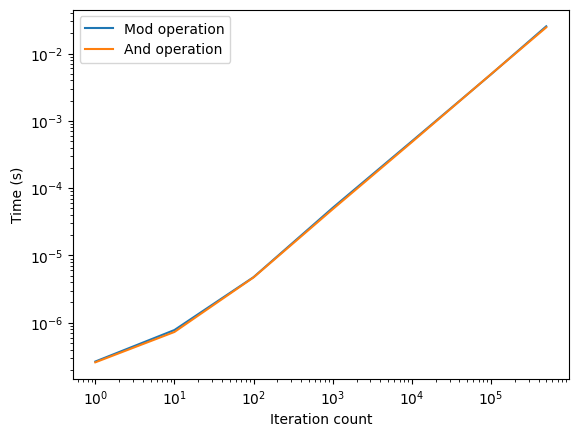

Bitwise AND is faster by roughly 2.901546 percent


In [86]:
import timeit
import time
import matplotlib.pyplot as plt
from statistics import mean

mod = 2**16
a = 1103515245
c = 1
seed = time.time_ns() % mod


def mod_operation(n: int, seed: int, a: int, c: int, mod: int) -> int:
    prevX = seed
    for _ in range(n):
        prevX = (a * prevX + c) % mod
    return prevX


def and_operation(n: int, seed: int, a: int, c: int, mask: int) -> int:
    prevX = seed
    for _ in range(n):
        prevX = (a * prevX + c) & mask
    return prevX


def measure_time(func, *args) -> float:
    warmup_iterations = 10
    actual_iterations = 100

    # Warm-up runs
    for _ in range(warmup_iterations):
        func(*args)

    times = timeit.repeat(lambda: func(*args), number=1, repeat=actual_iterations)
    return mean(times)


iteration_counts = [1, 10, 100, 1000, 10000, 100000, 500000]

mod_times = [measure_time(mod_operation, n, seed, a, c, mod) for n in iteration_counts]
and_times = [
    measure_time(and_operation, n, seed, a, c, mod - 1) for n in iteration_counts
]

plt.plot(iteration_counts, mod_times, label="Mod operation")
plt.plot(iteration_counts, and_times, label="And operation")

plt.xlabel("Iteration count")
plt.ylabel("Time (s)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

print(f"Bitwise AND is faster by roughly {100 * (1 - mean(and_times) / mean(mod_times)):2f} percent")


W naszym prostym teście możemy zauważyć, że operacja modulo rzeczywiście jest bardziej kosztowna, więc $m$ będące potęgą $2$ jest atrakcyjne. Oczywiście ten benchmark nie jest bardzo dokładny, ale pokazuje, że warto zwrócić na to uwagę.

